In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.init as init
from torchsummary import summary

# Data

In [27]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, ), (0.5, ))])

trainset = torchvision.datasets.FashionMNIST(root='Data',
                                             train=True,
                                             download=True,
                                             transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=1024,
                                          num_workers=5,
                                          shuffle=True,
                                          drop_last=False)

testset = torchvision.datasets.FashionMNIST(root='Data',
                                            train=False,
                                            download=True,
                                            transform=transform)
testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=1024,
                                         num_workers=5,
                                         shuffle=False)

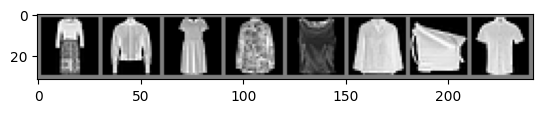

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display the images
def imshow(img):
    img = img*0.5 + 0.5
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

for i, (images, labels) in enumerate(trainloader, 0):
    # Plot some images
    imshow(torchvision.utils.make_grid(images[:8]))  # Display 8 images from the batch
    break

# Model

In [29]:
class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.conv = nn.Conv2d(in_channels=1, 
                              out_channels=32,
                              kernel_size=5)
        self.pool = nn.MaxPool2d(2,2)
        self.flatten = nn.Flatten()
        self.dense1 = nn.Linear(12*12*32, 128)
        self.dense2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.relu(self.dense1(x))
        x = self.dense2(x)
        return x

In [30]:
model = CustomModel()
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 24, 24]             832
              ReLU-2           [-1, 32, 24, 24]               0
         MaxPool2d-3           [-1, 32, 12, 12]               0
           Flatten-4                 [-1, 4608]               0
            Linear-5                  [-1, 128]         589,952
              ReLU-6                  [-1, 128]               0
            Linear-7                   [-1, 10]           1,290
Total params: 592,074
Trainable params: 592,074
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.35
Params size (MB): 2.26
Estimated Total Size (MB): 2.62
----------------------------------------------------------------


# Loss, Optimizer and Evaluate Fuction

In [31]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),
                       lr=1e-4)

In [32]:
def evaluate(model, testloader, loss_fn):
    model.eval()
    running_loss = 0.0
    running_correct = 0.0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:

            outputs = model(images)
            loss = loss_fn(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

    test_accuracy = running_correct * 100 / total
    test_loss = running_loss / len(testloader)
    return test_accuracy, test_loss

# Train

In [33]:
train_accuracies = []
train_losses = []

test_accuracies = []
test_losses = []

max_epoch = 20

In [34]:
for epoch in range(max_epoch):
    model.train()
    running_loss = 0.0
    running_correct = 0.0
    total = 0

    for i, (images, labels) in enumerate(trainloader, 0):

        outputs = model(images)
        loss = loss_fn(outputs, labels)
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        running_correct += (predicted == labels).sum().item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = running_loss / (i+1)
    train_losses.append(epoch_loss)
    epoch_accuracy = running_correct * 100 / total
    train_accuracies.append(epoch_accuracy)

    test_accuracy, test_loss = evaluate(model, testloader, loss_fn)
    test_accuracies.append(test_accuracy)
    test_losses.append(test_loss)

    print(f"Epoch [{epoch + 1}/{max_epoch}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")  

Epoch [1/20], Loss: 1.2813, Accuracy: 65.76%, Test Loss: 0.7770, Test Accuracy: 73.88%
Epoch [2/20], Loss: 0.6578, Accuracy: 77.63%, Test Loss: 0.6036, Test Accuracy: 78.86%
Epoch [3/20], Loss: 0.5474, Accuracy: 81.19%, Test Loss: 0.5337, Test Accuracy: 81.07%
Epoch [4/20], Loss: 0.4910, Accuracy: 83.17%, Test Loss: 0.4910, Test Accuracy: 82.77%
Epoch [5/20], Loss: 0.4544, Accuracy: 84.39%, Test Loss: 0.4615, Test Accuracy: 83.71%
Epoch [6/20], Loss: 0.4282, Accuracy: 85.28%, Test Loss: 0.4420, Test Accuracy: 84.40%
Epoch [7/20], Loss: 0.4081, Accuracy: 85.92%, Test Loss: 0.4224, Test Accuracy: 85.45%
Epoch [8/20], Loss: 0.3923, Accuracy: 86.42%, Test Loss: 0.4099, Test Accuracy: 85.65%
Epoch [9/20], Loss: 0.3785, Accuracy: 86.91%, Test Loss: 0.3983, Test Accuracy: 86.18%
Epoch [10/20], Loss: 0.3680, Accuracy: 87.22%, Test Loss: 0.3890, Test Accuracy: 86.46%
Epoch [11/20], Loss: 0.3576, Accuracy: 87.68%, Test Loss: 0.3790, Test Accuracy: 86.96%
Epoch [12/20], Loss: 0.3485, Accuracy: 88

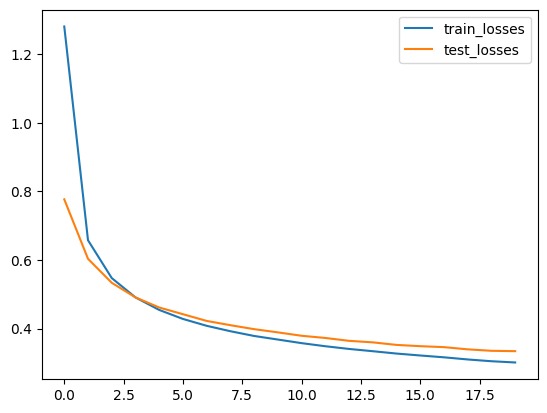

In [35]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='train_losses')
plt.plot(test_losses, label='test_losses')
plt.legend()

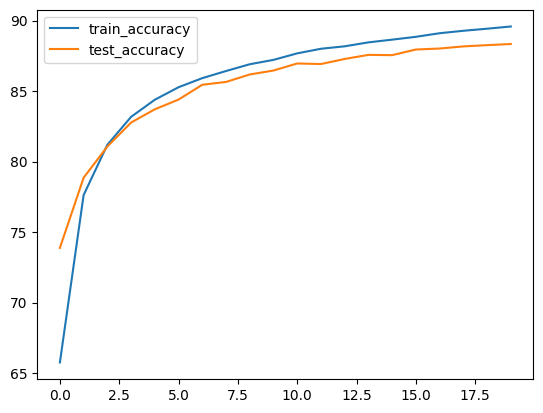

In [36]:
import matplotlib.pyplot as plt

plt.plot(train_accuracies, label='train_accuracy')
plt.plot(test_accuracies, label='test_accuracy')
plt.legend()